In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

##### Load the dataset

In [2]:
df = pd.read_csv('data_cleaned_mos.csv')

In [4]:
null_counts = df.isnull().sum()
print("Null/Empty counts for each column:")
print(null_counts)

Null/Empty counts for each column:
timestamp_call_key                        0
retailer_code                             0
serial                                    0
reason                                    0
mos                                       0
resolved                                  0
no_of_accounts_with_syf_13_march       3400
account_balance_13_march             113782
delinquency_history_13_march              0
account_open_date_13_march                0
account_status_13_march                   0
card_activation_status_13_march           0
eservice_ind_13_march                     0
ebill_enrolled_status_13_march            0
auto_pay_enrolled_status_13_march         0
no_of_accounts_with_syf_18_march       3402
account_balance_18_march             101829
delinquency_history_18_march              0
account_open_date_18_march                0
account_status_18_march                   0
card_activation_status_18_march           0
eservice_ind_18_march                    

Most common paths

In [12]:
from collections import Counter

mos_sequences = df['cleaned_mos'].str.split().apply(tuple) 
most_common_paths = Counter(mos_sequences).most_common()

In [7]:
unique_data_types = df['cleaned_mos'].apply(type).unique()
print(unique_data_types)

[<class 'str'> <class 'float'>]


In [8]:
float_rows = df[df['cleaned_mos'].apply(type) == float]
print(float_rows)

            timestamp_call_key retailer_code       serial reason          mos  \
3        240314120849 PHX6PL4U             E  10008003199     BA        IA BA   
6        240316012428 PHX43JOI             E  10006032399     BA        IA BA   
7        240316171347 PHX4I164             B  10002094529     BA        IA BA   
8        240316171945 DAL16OYM             B  10002094529     BA  IA IA IA BA   
22       240315161527 DAL5NC9N             B  10007016674     BA        IA BA   
...                        ...           ...          ...    ...          ...   
1798697  240317135028 PHX3JEM2             C  20003069288     BA        IA BA   
1798698  240316215117 PHX5MN65             H  20009019173     mn     mn IA TR   
1798721  240314215722 PHX7KXNL             I  20022001348     BA     IA IA BA   
1798794  240314120336 DAL4K2UN             I  20012001463     BA        IA BA   
1798796  240317213341 PHX35A2C             D  20010020211     FD     IA IA TR   

         resolved  no_of_ac

In [11]:
nan_count = df['cleaned_mos'].isna().sum()
print("Number of NaN values in 'cleaned_mos' column:", nan_count)

Number of NaN values in 'cleaned_mos' column: 0


In [10]:
df.dropna(subset=['cleaned_mos'], inplace=True)

In [ ]:
import matplotlib.pyplot as plt

mos_labels = [' '.join(mos) for mos, count in most_common_paths[:10]]
counts = [count for mos, count in most_common_paths[:10]]

plt.figure(figsize=(10, 8))
plt.barh(mos_labels, counts)
plt.xlabel('Frequency')
plt.ylabel('MOS Path')
plt.title('Top 10 Most Common MOS Paths')
plt.gca().invert_yaxis() 
plt.show()


In [105]:
print(most_common_paths[:10])

[(('IA', 'PP', 'TR'), 466412), (('mn', 'IA', 'PP', 'TR'), 137569), (('IA', 'BA'), 116279), (('IA', 'IA', 'PP', 'TR'), 46700), (('IA', 'BA', 'TS', 'nl', 'PT', 'TR'), 43145), (('IA', 'BA', 'TS'), 30003), (('IA', 'PP', 'BA'), 29874), (('IA', 'PI', 'BA'), 28304), (('mn', 'IA', 'BA'), 24763), (('IA', 'PP', 'BA', 'TS', 'nl', 'PT', 'TR'), 15463)]


In [47]:
mos_sequences_df = df['cleaned_mos'].str.split().apply(tuple).to_frame(name='mos_sequence_tuple').copy()
mos_sequences_df['resolved_status'] = df['resolved']

grouped_counts = mos_sequences_df.groupby(['mos_sequence_tuple', 'resolved_status']).size().unstack(fill_value=0)

grouped_counts['total_occurrences'] = grouped_counts['resolved'] + grouped_counts['floor']

grouped_counts['floor_percentage'] = (grouped_counts['floor'] / grouped_counts['total_occurrences']) * 100

sorted_grouped_counts = grouped_counts.sort_values(by='floor_percentage', ascending=False)

sorted_grouped_counts.reset_index(inplace=True)

sorted_grouped_counts['mos_sequence'] = sorted_grouped_counts['mos_sequence_tuple'].apply(lambda x: ' '.join(x))

mos_df = sorted_grouped_counts[['mos_sequence', 'floor_percentage', 'total_occurrences', 'resolved', 'floor']].copy()

mos_df.rename(columns={
    'mos_sequence': 'MOS Sequence',
    'floor_percentage': 'Floor Call Percentage',
    'total_occurrences': 'Total Occurrences',
    'resolved': 'Number of Resolved Calls',
    'floor': 'Number of Floor Calls'
}, inplace=True)


In [48]:
w_fp = 0.6 
w_to = 0.4

mos_df['weighted_score'] = (w_fp + w_to) / ((w_fp / (mos_df['Floor Call Percentage'] + 1)) + (w_to / (mos_df['Total Occurrences'] + 1)))

mos_df_sorted = mos_df.sort_values(by='weighted_score', ascending=False)

print(mos_df_sorted[['MOS Sequence', 'Floor Call Percentage', 'Total Occurrences', 'weighted_score']].head(10))


resolved_status       MOS Sequence  Floor Call Percentage  Total Occurrences  \
11408                  TS nl mt RS              99.703634              19233   
11394                     nl mt RS              99.782459               8734   
11390                  PP nl mt RS              99.815186               6493   
11402               PI TS nl mt RS              99.743357               6624   
11397               PP TS nl mt RS              99.754902               6528   
11424               TS nl nl mt RS              99.524394               6518   
11412               TS mm mo mt RS              99.661017               3835   
11405                  PI nl mt RS              99.717514               2832   
11388            TS nl mm mo mt RS              99.863884               2204   
11422            PI TS nl nl mt RS              99.549918               2444   

resolved_status  weighted_score  
11408                167.255590  
11394                166.688622  
11390            

In [40]:
mos_df_sorted.head(2)

resolved_status,MOS Sequence,Floor Call Percentage,Total Occurrences,Number of Resolved Calls,Number of Floor Calls,weighted_score
11408,TS nl mt RS,99.703634,19233,57,19176,167.255590
11394,nl mt RS,99.782459,8734,19,8715,166.688622


In [49]:

keywords_to_remove = ['nl', 'mt', 'mo', 'mm', 'mn']

def remove_keywords(sequence):
    words = sequence.split()
    cleaned_words = [word for word in words if word not in keywords_to_remove]
    return ' '.join(cleaned_words)

mos_df_sorted['MOS Sequence'] = mos_df_sorted['MOS Sequence'].apply(remove_keywords)

print(mos_df_sorted['MOS Sequence'])

11408          TS RS
11394             RS
11390          PP RS
11402       PI TS RS
11397       PP TS RS
            ...     
16085          AA SP
18805    AA TS AT mp
18804       AA TS AT
18803             iR
17265    DR IC mp IC
Name: MOS Sequence, Length: 23155, dtype: object


In [50]:
mos_df_sorted.dropna(subset=['MOS Sequence'], inplace=True)


In [51]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

weighted_score = mos_df_sorted[['weighted_score']]

mos_df_sorted['normalized_weighted_score'] = scaler.fit_transform(weighted_score)

print(mos_df_sorted)

resolved_status MOS Sequence  Floor Call Percentage  Total Occurrences  \
11408                  TS RS              99.703634              19233   
11394                     RS              99.782459               8734   
11390                  PP RS              99.815186               6493   
11402               PI TS RS              99.743357               6624   
11397               PP TS RS              99.754902               6528   
...                      ...                    ...                ...   
16085                  AA SP               0.000000                  1   
18805            AA TS AT mp               0.000000                  1   
18804               AA TS AT               0.000000                  1   
18803                     iR               0.000000                  1   
17265            DR IC mp IC               0.000000                  1   

resolved_status  Number of Resolved Calls  Number of Floor Calls  \
11408                                  57  

In [52]:

mos_df_sorted.drop(columns=['Floor Call Percentage', 'weighted_score', 'normalized_weighted_score'], inplace=True)

grouped_df = mos_df_sorted.groupby('MOS Sequence').sum().reset_index()

grouped_df['Floor Percentage'] = (grouped_df['Number of Floor Calls'] / grouped_df['Total Occurrences']) * 100


grouped_df.sort_values(by='Floor Percentage', ascending=False, inplace=True)

print(grouped_df)


resolved_status       MOS Sequence  Total Occurrences  \
8266                      TS WA eY                  1   
3209                   OC OB me eL                  1   
3226                   PA CT CT RS                  2   
3225                PA CT CT CT RS                  1   
3224                PA CT CT CT CT                  1   
...                            ...                ...   
4813             PI TS mp MP CA TD                  1   
4821                PI TS mp MP PT                  4   
4827                PI TS mp MP SR                  1   
4828             PI TS mp MP WA PS                  1   
9234                   wa mp MP mp                  1   

resolved_status  Number of Resolved Calls  Number of Floor Calls  \
8266                                    0                      1   
3209                                    0                      1   
3226                                    0                      2   
3225                                    0  

In [57]:

w_fp = 0.6
w_to = 0.4
grouped_df['weighted_score'] = (w_fp + w_to) / ((w_fp / (grouped_df['Floor Percentage'] + 1)) + (w_to / (grouped_df['Total Occurrences'] + 1)))

grouped_df = grouped_df.sort_values(by='weighted_score', ascending=False)

print(grouped_df[['MOS Sequence', 'Floor Percentage', 'Total Occurrences', 'weighted_score']].head(10))

resolved_status MOS Sequence  Floor Percentage  Total Occurrences  \
8037                   TS RS         99.668456              34083   
6975                      RS         99.712174              12855   
6144                PP TS RS         99.675519              11711   
4442                PI TS RS         99.643242              12053   
5625                   PP RS         99.804147               8680   
3748                   PI RS         99.611134               4886   
7448                TS CT RS         99.682540               3150   
2048                   CT RS         99.707174               2732   
909                 AA TS RS         99.727308               2567   
462              AA Mr TS RS         98.715203               2335   

resolved_status  weighted_score  
8037                 167.451045  
6975                 166.981550  
6144                 166.836455  
4442                 166.810231  
5625                 166.716301  
3748                 165.414903  
74

In [61]:

scaler = MinMaxScaler()

weighted_score = grouped_df[['weighted_score']]

grouped_df['normalized_weighted_score'] = scaler.fit_transform(weighted_score)

print(grouped_df[['MOS Sequence', 'Floor Percentage', 'Total Occurrences', 'weighted_score', 'normalized_weighted_score']].head(10))


resolved_status MOS Sequence  Floor Percentage  Total Occurrences  \
8037                   TS RS         99.668456              34083   
6975                      RS         99.712174              12855   
6144                PP TS RS         99.675519              11711   
4442                PI TS RS         99.643242              12053   
5625                   PP RS         99.804147               8680   
3748                   PI RS         99.611134               4886   
7448                TS CT RS         99.682540               3150   
2048                   CT RS         99.707174               2732   
909                 AA TS RS         99.727308               2567   
462              AA Mr TS RS         98.715203               2335   

resolved_status  weighted_score  normalized_weighted_score  
8037                 167.451045                   1.000000  
6975                 166.981550                   0.997175  
6144                 166.836455                   0.99630

In [62]:
grouped_df.to_csv('cleaned_mos_analysis_weighted.csv', index=False)

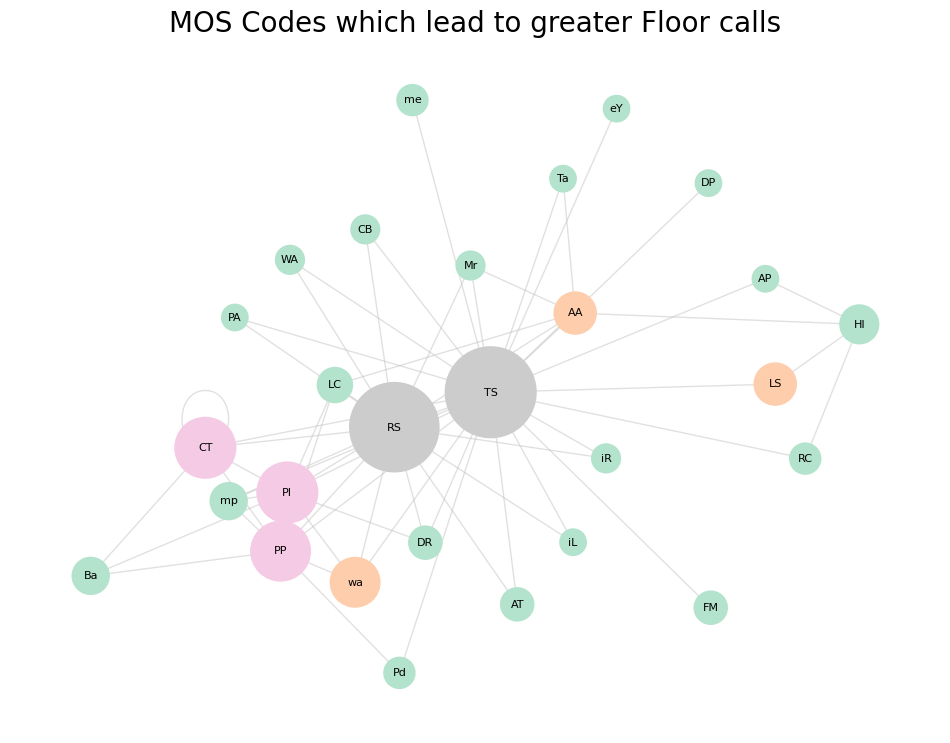

In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects 

file_path = 'cleaned_mos_analysis_weighted.csv' 
data = pd.read_csv(file_path)

data_subset = data.head(100)

G = nx.Graph()

node_sizes = {}

for seq in data_subset['MOS Sequence']:
    nodes = seq.split()
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1])
        node_sizes[nodes[i]] = node_sizes.get(nodes[i], 0) + 1
    node_sizes[nodes[-1]] = node_sizes.get(nodes[-1], 0) + 1

max_size = max(node_sizes.values())
min_size = min(node_sizes.values())
normalized_sizes = {node: ((size - min_size) / (max_size - min_size) * 200 + 20) for node, size in node_sizes.items()}

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 9), facecolor='white')
ax = plt.gca()

nodes = nx.draw_networkx_nodes(G, pos, node_size=[normalized_sizes[node] * 20 for node in G.nodes()],
                               node_color=[normalized_sizes[node] for node in G.nodes()],
                               cmap=plt.cm.Pastel2, alpha=1.0, edgecolors='#141414', linewidths=0)

edges = nx.draw_networkx_edges(G, pos, edge_color='#c4c3c3', alpha=0.5, width=1)

labels = nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

plt.title("MOS Codes which lead to greater Floor calls", fontsize=20)
plt.axis('off')
plt.show()


Saving all nodes and edges

In [67]:
import pandas as pd

file_path = 'cleaned_mos_analysis_weighted.csv' 
data = pd.read_csv(file_path)

data_subset = data.head(100)

nodes = set()
edges = []

for index, row in data_subset.iterrows():
    sequence = row['MOS Sequence'].split()
    normalized_weighted_score = row['normalized_weighted_score']
    for i in range(len(sequence) - 1):
        source = sequence[i]
        target = sequence[i + 1]
        edges.append((source, target, normalized_weighted_score))
        nodes.add(source)
        nodes.add(target)

nodes_df = pd.DataFrame({'Id': list(nodes)})
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])

nodes_file_path = 'nodes.csv'
edges_file_path = 'edges.csv'

nodes_df.to_csv(nodes_file_path, index=False)
edges_df.to_csv(edges_file_path, index=False)

print(f"Nodes and edges CSV files have been saved to {nodes_file_path} and {edges_file_path}, respectively.")

Nodes and edges CSV files have been saved to nodes.csv and edges.csv, respectively.
